# Testing Yan et al. (2010, 2011) on the Radio Galaxy Zoo

Let's run the crowd learning algorithm on the Radio Galaxy Zoo.

In [1]:
import sys

import h5py
import numpy
import sklearn.neighbors

sys.path.insert(1, '..')
import crowdastro.active_learning.active_crowd as active_crowd
import crowdastro.active_learning.passive_crowd as passive_crowd

CROWDASTRO_H5_PATH = '../data/crowdastro.h5'
TRAINING_H5_PATH = '../data/training.h5'

## How many annotators do we have? How many labels are anonymously contributed?

At the moment, I can only use the algorithm for non-anonymous users. How many are there?

In [2]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    print(sum(1 for i in f_h5['/atlas/cdfs/']['classification_usernames'] if not i)
          / len(f_h5['/atlas/cdfs/']['classification_usernames']))

0.14638396747022944


Only 15% of labels are contributed by anonymous users! That's great for the algorithm. How many users are there?

In [3]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    print(len({i for i in f_h5['/atlas/cdfs/']['classification_usernames'] if i}))

1193


There are 1193 labellers. That's big but hopefully my code can handle it (and if not I'll have to change my methodology a bit).

## Retrieving labels

 Let's pull out some labels. This involves matching each IR object to a label for each annotator. If a IR object never appears in a subject that the annotator has labelled, then it should be masked.

In [4]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    annotators = sorted({i for i in f_h5['/atlas/cdfs/classification_usernames'] if i})
    n_annotators = len(annotators)
    annotator_to_index = {j:i for i, j in enumerate(annotators)}
    
    n_examples = f_h5['/wise/cdfs/numeric'].shape[0]
    
    ir_tree = sklearn.neighbors.KDTree(f_h5['/wise/cdfs/numeric'][:, :2], metric='chebyshev')

In [5]:
with h5py.File(CROWDASTRO_H5_PATH) as f_h5:
    labels = numpy.ma.MaskedArray(numpy.zeros((n_annotators, n_examples)),
                                  mask=numpy.ones((n_annotators, n_examples)))
    
    for (atlas_idx, ra, dec), c_user in zip(
            f_h5['/atlas/cdfs/classification_positions'],
            f_h5['/atlas/cdfs/classification_usernames'],
    ):
        if not c_user:
            continue

        t = annotator_to_index[c_user]
        
        atlas_ra, atlas_dec = f_h5['/atlas/cdfs/numeric'][atlas_idx, :2]
        
        # t has seen this ATLAS subject, so unmask everything within 1' Chebyshev distance (the radius of an RGZ subject).
        nearby = ir_tree.query_radius([[atlas_ra, atlas_dec]], 1 / 60)[0]
        labels.mask[t, nearby] = 0

        # Label the point nearest the classification as 1.
        # (The others are 0 by default.)
        if numpy.isnan(ra) or numpy.isnan(dec):
            continue

        point = ir_tree.query([[ra, dec]], return_distance=False)[0]
        labels[t, point] = 1

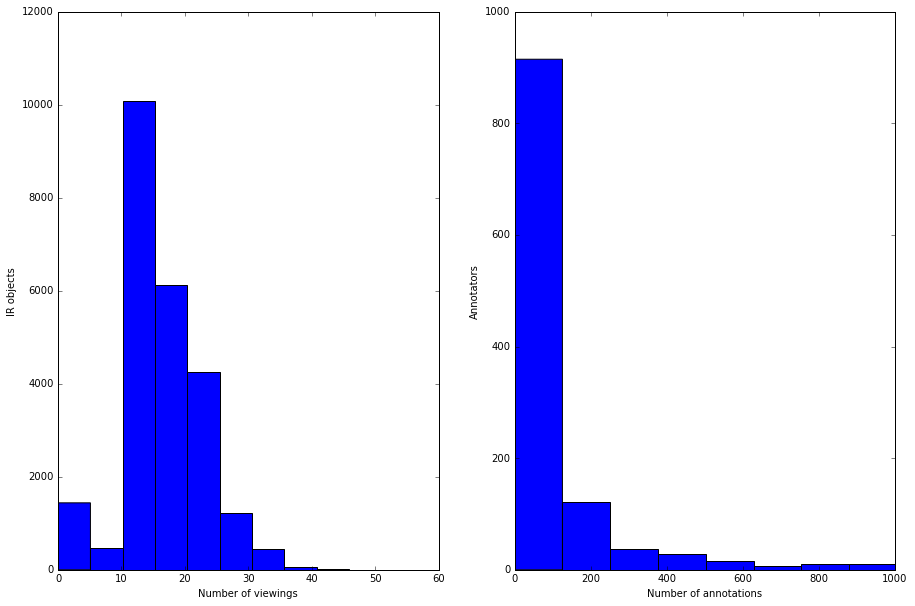

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.hist((~labels.mask).sum(axis=0))
plt.xlabel('Number of viewings')
plt.ylabel('IR objects')
plt.subplot(1, 2, 2)
plt.hist((~labels.mask).sum(axis=1), bins=numpy.linspace(0, 25000, 200))
plt.xlim((0, 1000))
plt.xlabel('Number of annotations')
plt.ylabel('Annotators')

## Running the algorithm

Let's throw it in and see how it goes. First, I'll downsample the negative examples. I'll count a "negative" example as anything that doesn't have any positive classifications.

In [45]:
non_negative_bool = numpy.any(labels, axis=0)
non_negatives = numpy.arange(labels.shape[1])[non_negative_bool]
negatives = numpy.arange(labels.shape[1])[~non_negative_bool]

numpy.random.shuffle(negatives)
negatives = negatives[:non_negatives.shape[0]]

In [47]:
assert negatives.shape == non_negatives.shape

downsampled = numpy.hstack([non_negatives, negatives])
downsampled.sort()

Now I can run the algorithm.

In [58]:
import logging
logging.getLogger('active_crowd').setLevel(logging.INFO)

with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features'][downsampled, :]
    res = active_crowd.train(x, labels.astype(bool)[:, downsampled], lr_init=True)

..\crowdastro\active_learning\active_crowd.py:46: RuntimeWarning: divide by zero encountered in log
  numpy.log((1 - posts)), posteriors_0)
..\crowdastro\active_learning\active_crowd.py:47: RuntimeWarning: invalid value encountered in log
  expectation += numpy.ma.sum(numpy.ma.dot(numpy.log(annos), posteriors))
..\crowdastro\active_learning\active_crowd.py:48: RuntimeWarning: invalid value encountered in log
  expectation += numpy.ma.sum(numpy.ma.dot(numpy.log(annos_0), posteriors_0))


In [59]:
import sklearn.metrics

with h5py.File(TRAINING_H5_PATH) as f_h5:
    x = f_h5['features']
    pred = passive_crowd.predict(res[0], res[1], x)
    print(sklearn.metrics.accuracy_score(f_h5['labels'].value, pred, normalize=True))
    cm = sklearn.metrics.confusion_matrix(f_h5['labels'].value, pred)
    print(cm)

0.906752278376
[[21883     0]
 [ 2251     6]]
